In [2]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

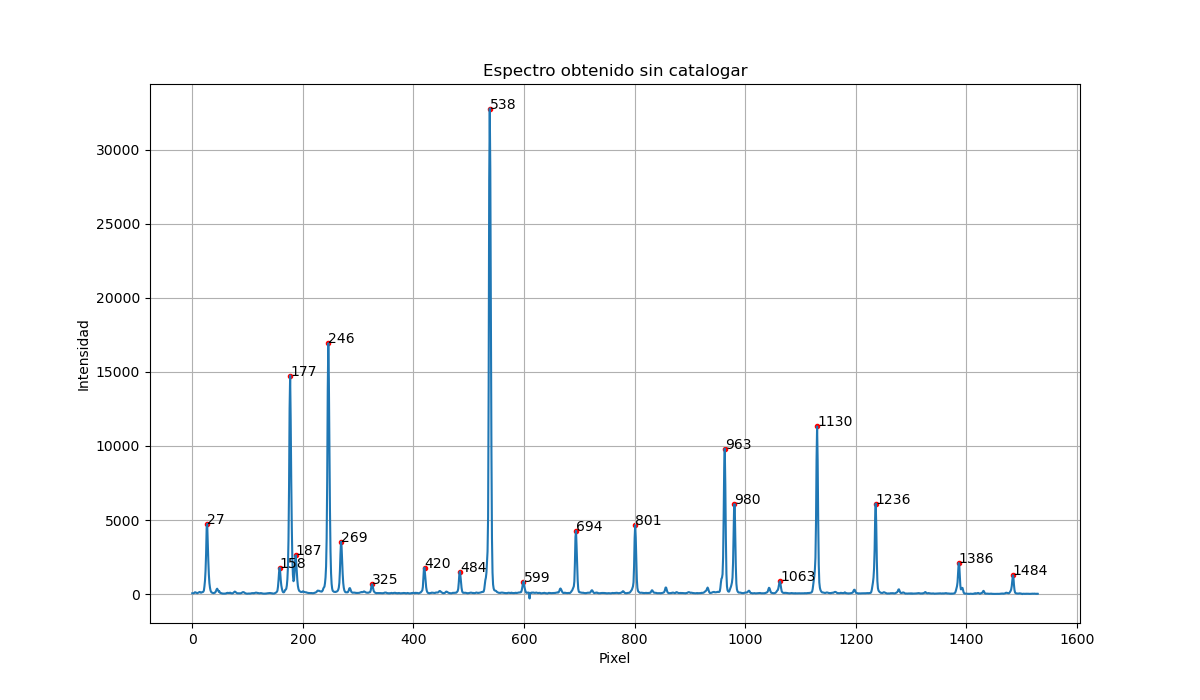

In [3]:
def Spectrum(datax,datay):
    marker_x = []
    marker_y = []
    index_y = []
    index_x = []
    anotaciones = []

    for i in range(0,len(datax)):
        mark = i

        if mark != 0 and mark != len(datax)-1:
            last = datay[mark - 1]
            next = datay[mark + 1]

            #Hallar máximos de espectro
            if (last < datay[i]) and (next < datay[i]) and (datay[i]>525) and (datay[i]!=187):
                marker_x.append(datax[i])
                marker_y.append(datay[i])

                index_y.append( datay[i-7:i+7] )
                index_x.append( datax[i-7:i+7] )

                anotaciones.append(str(datax[i]))
                
    return marker_x,marker_y,index_x,index_y,anotaciones

def DataProcess(l):
    data = pd.read_csv(l, delimiter=' ')
    pixel = np.array(data['P'])
    intensidad = np.array(data['I'])

    marker_x,marker_y, index_x,index_y,anotaciones = Spectrum(pixel,intensidad)
    return pixel,intensidad,marker_x,marker_y, index_x,index_y,anotaciones

pixel,intensidad,marker_x,marker_y, index_x,index_y,anotaciones = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\th 6200 orden 2 spec.txt")

#Grafica
fig1, ax1 = plt.subplots(1,1, figsize=(12,7))
ax1.plot(pixel,intensidad)
ax1.scatter(marker_x,marker_y,marker='.',color = 'red')
ax1.set_title('Espectro obtenido sin catalogar')
ax1.set_xlabel('Pixel')
ax1.set_ylabel('Intensidad')
ax1.grid()
for i, label in enumerate(anotaciones):
    plt.annotate(label, (marker_x[i] + 0.1, marker_y[i]))
#fig1.savefig('th 6200 orden 2 espectro tratado.jpg')

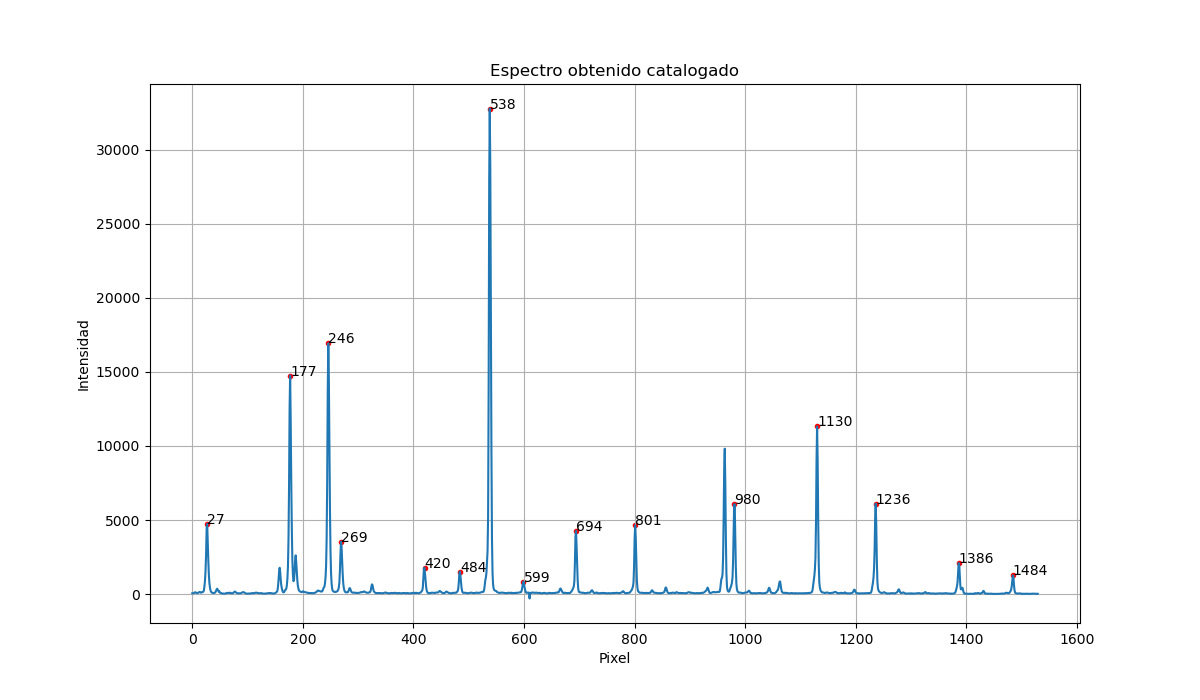

In [4]:
#Parte para retirar aquellas líneas que no aparecen en el catálogo o no ayudan a la obtención de la lorentziana
def DataCatalogue(pixs,marker_x,marker_y, index_x,index_y,anotaciones):
    mar_x = []
    mar_y = []
    ind_y = []
    ind_x = []
    anot = []
   

    for i in range(0,len(marker_x)):
        if marker_x[i] not in pixs:
            mar_x.append(marker_x[i])
            mar_y.append(marker_y[i])
            ind_x.append(index_x[i])
            ind_y.append(index_y[i])
            anot.append(anotaciones[i])

    return mar_x,mar_y, ind_x,ind_y,anot

PixSus = [158,187,325,963,1063]
marker_x,marker_y, index_x,index_y,anotaciones = DataCatalogue(PixSus,marker_x,marker_y, index_x,index_y,anotaciones)
    
#Grafica
fig2, ax2 = plt.subplots(1,1, figsize=(12,7))
ax2.plot(pixel,intensidad)
ax2.scatter(marker_x,marker_y,marker='.',color = 'red')
ax2.set_title('Espectro obtenido catalogado')
ax2.set_xlabel('Pixel')
ax2.set_ylabel('Intensidad')
ax2.grid()
for i, label in enumerate(anotaciones):
    plt.annotate(label, (marker_x[i] + 0.1, marker_y[i]))
#fig2.savefig('th 6200 orden 2 espectro tratado.jpg')



In [5]:
#Ajuste de Lorentz

def Lorentzian(x,h,x0,W):
    return h*W**2/((x-x0)**2+W**2)

def AjusteLorentz(i):
    x = index_x[i]
    y = index_y[i] 
    x_1 = np.linspace(x[0],x[-1],500 )

    popt, _ = curve_fit(Lorentzian,x,y) 
    h = popt[0]
    x0 = popt[1]
    w = popt[2]

    fit_y= Lorentzian(x_1,h,x0,w)

    return x0,h,fit_y,x_1, x, y

def MakeDataFrame(rango,catalog_long):

    Datafit = pd.DataFrame()
    lineasfit = []
    alturafit = []

    for i in range(0,rango):
        linea,altura, fity, fitx, x, y = AjusteLorentz(i)
        lineasfit.append(linea)
        alturafit.append(altura)
    

    Datafit['Pixel'] = lineasfit
    Datafit['Instensidad'] = alturafit
    Datafit['Catalogo longitud'] = catalog_long

    return Datafit

catalog_long = [ 6164.48, 6169.82, 6172.28, 6173.10, 6178.43, 6180.71, 6182.62, 6184.78, 6188.13, 6191.91, 6198.22, 6203.49, 6207.22, 6212.51, 6215.95 ]
DataFit = MakeDataFrame(len(marker_x),catalog_long)
DataFit

,Pixel,Instensidad,Catalogo longitud
0,26.739237,5001.843023,6164.48
1,177.003305,15353.196491,6169.82
2,246.166012,17790.356097,6172.28
3,269.326072,3712.917762,6173.10
4,419.733042,1940.660105,6178.43
5,483.937532,1615.436804,6180.71
6,538.155619,35320.053900,6182.62
7,598.895878,875.488513,6184.78
8,693.850607,4563.389237,6188.13
9,801.067003,4910.602039,6191.91


In [6]:
def LinearFit(datax,datay,n):
    param = np.polyfit(datax,datay, n)
    _x = np.linspace(min(datax),max(datax),len(datax))
    res = []
    ym = []
    xm = []
    xres = []

    for i in range(0,len(datax)):
        ym.append((_x[i]**n)*param[0] + (_x[i]**(n-1))*param[1] + (_x[i]**(n-2))*param[2] + param[3]) 
        xm.append(_x[i])
        ye = param[0]*(datax[i]**n) + param[1]*(datax[i]**(n-1)) + param[2]*(datax[i]**(n-2)) + param[3]
        res.append(ye-datay[i])
        xres.append(datax[i])

    #Solo descomentar si es necesario revisar el grado de los residuos
    # paramr = np.polyfit(xres,res, 3)
    # ymr = xres*xres*xres*paramr[0] + xres*xres*paramr[1] + xres*paramr[2] + paramr[3] 
    return ym,xm,res,xres,param


ym,_x,res,xres,param = LinearFit(DataFit['Pixel'],DataFit['Catalogo longitud'], 3) 

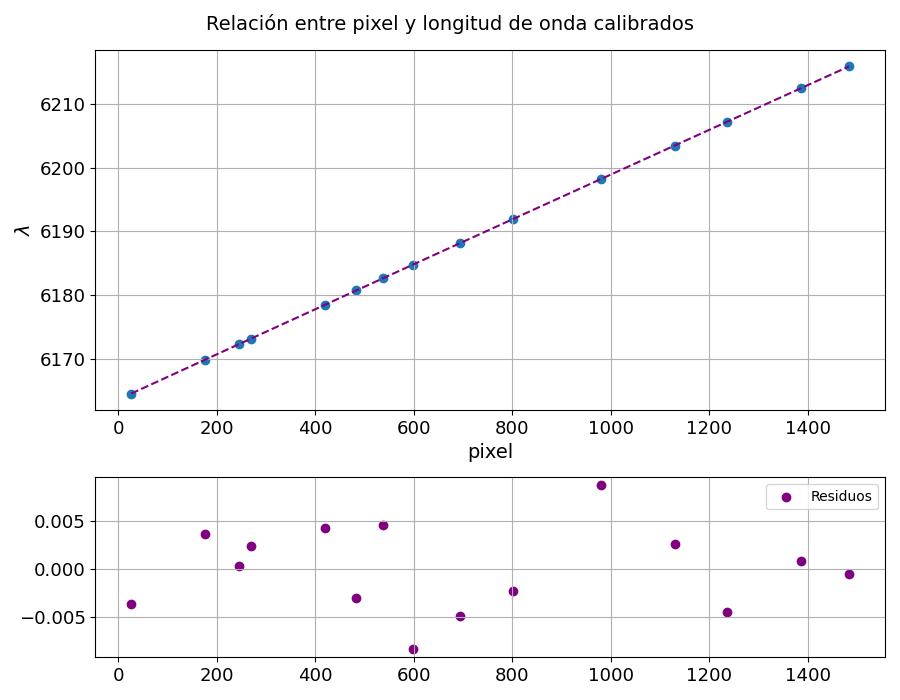

In [7]:
#Gráfico con residuos
fig1, axis1 = plt.subplots(2,1, figsize = (9, 7), gridspec_kw = {"height_ratios":[2, 1]})
ax1 = axis1[0]
ax2 = axis1[1]

fig1.suptitle(r'Relación entre pixel y longitud de onda calibrados',fontsize=14)

ax1.scatter(DataFit['Pixel'],DataFit['Catalogo longitud'])
ax1.plot(_x,ym,'--',color='purple')
ax1.set_ylabel(r"$\lambda$",fontsize=14)
ax1.set_xlabel(r'pixel',fontsize=14)
ax1.grid()
ax1.tick_params(axis='both',labelsize=13)

ax2.scatter(xres,res,label = 'Residuos',color='purple')
ax2.grid()
ax2.tick_params(axis='both',labelsize=13)
ax2.legend()
ax1.set_xlabel(r'pixel',fontsize=14)

fig1.tight_layout()
#fig1.savefig('DvsV.jpg')


In [8]:
def Calibration(pix,param):
    return ((pix)**3)*param[0] + ((pix)**2)*param[1] + (pix)*param[2] + param[3]

def LineasSus(pixs):
    Data = pd.DataFrame()
    Data['Pixel'] = pixs
    Orden1 = []
    Orden2 = []
    Orden3 = []
    for i in pixs:
        Orden1.append(Calibration(i,param)*2)
        Orden2.append(Calibration(i,param)) 
        Orden3.append(Calibration(i,param)*(2/3)) 
    
    Data['Calibracion orden 1'] = Orden1
    Data['Calibracion orden 2'] = Orden2
    Data['Calibracion orden 3'] = Orden3

    return Data



LineasSos = LineasSus(PixSus)
LineasSos['NIST orden 3'] = [4112.754,None , 4116.713, 4131.723, 4134.0678]
LineasSos['Elemento'] = [ 'Th I ', 'Mezcla', 'Th II', 'Ar II', 'Th I']
LineasSos

,Pixel,Calibracion orden 1,Calibracion orden 2,Calibracion orden 3,NIST orden 3,Elemento
0,158,12338.296315,6169.148158,4112.765438,4112.7540,Th I
1,187,12340.357812,6170.178906,4113.452604,NaN,Mezcla
2,325,12350.154734,6175.077367,4116.718245,4116.7130,Th II
3,963,12395.228826,6197.614413,4131.742942,4131.7230,Ar II
4,1063,12402.270745,6201.135372,4134.090248,4134.0678,Th I
